Heat Transfer 1D
================

In [1]:
# NOT WORKING
#%load_ext Cython
#%%cython -f -n CavityFlow2D --lib=petsc --lib=python3 
#-LD:\\Work\\Miniconda3\\envs\\petsc_debug\\Library\\lib 
#-I=./ -ID:\\Work\\Miniconda3\\envs\\petsc_debug\\lib\\site-packages\\petsc4py\\include 
#-ID:\\Work\\Miniconda3\\envs\\petsc_debug\\Library\\include\\ 
#-ID:\\Work\\Miniconda3\\envs\\petsc_debug\\Library\\include\\petsc\\mpiuni 
#--link-args=-debug --compile-args=-Zi --compile-args=/Od
#%save CavityFlow2D.pyx

file_content='''
from petsc4py.PETSc cimport Vec,  PetscVec
from petsc4py.PETSc cimport DM,   PetscDM
from petsc4py.PETSc cimport SNES, PetscSNES

from petsc4py.PETSc import Error

cdef extern from "HeatTransfer1Dimpl.h":
    ctypedef struct Params:
        double temperature_left_, temperature_right_, conductivity_
    int FormInitGuess(PetscDM da, PetscVec x, Params *p)
    int FormFunction (PetscDM da, PetscVec x, PetscVec F, Params *p)

def formInitGuess(Vec x, DM da, double temperature_left_, double temperature_right_, double conductivity_):
    cdef int ierr
    cdef Params p = {"temperature_left_" : temperature_left_, "temperature_right_" : temperature_right_, "conductivity_" : conductivity_}
    ierr = FormInitGuess(da.dm, x.vec, &p)
    if ierr != 0: raise Error(ierr)

def formFunction(SNES snes, Vec x, Vec f, DM da, double temperature_left_, double temperature_right_, double conductivity_):
    cdef int ierr
    cdef Params p = {"temperature_left_" : temperature_left_, "temperature_right_" : temperature_right_, "conductivity_" : conductivity_}

    ierr = FormFunction(da.dm, x.vec, f.vec, &p)
    if ierr != 0: raise Error(ierr)
'''

text_file = open("HeatTransfer1D.pyx", "w")

text_file.write(file_content)

text_file.close()

In [2]:
# First you need to call
!python setup.py build_ext --inplace

inside config
['D:/Miniconda3/envs/petsc_debug\\Library\\include', 'D:/Miniconda3/envs/petsc_debug\\Library\\include\\petsc\\mpiuni', 'D:\\Miniconda3\\envs\\petsc_debug\\lib\\site-packages\\petsc4py\\include']
running build_ext
running build_src
build_src
building extension "HeatTransfer1D" sources
cythonc:> .\HeatTransfer1D.c
build_src: building npy-pkg config files
No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
customize MSVCCompiler
customize MSVCCompiler using build_ext
building 'HeatTransfer1D' extension
compiling C sources
C:\Program Files (x86)\Microsoft Visual Studio 14.0\VC\BIN\x86_amd64\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -ID:\Miniconda3\envs\petsc_debug\Library\include -ID:\Miniconda3\envs\petsc_debug\Library\include\petsc\mpiuni -ID:\Miniconda3\envs\petsc_debug\lib\site-packages\petsc4py\include -I. -ID:\Miniconda3\envs\petsc_debug\lib\site-packages\numpy\core\include -ID:\Miniconda3\envs\petsc_debug\include -ID:\Miniconda3\

In [6]:
import argparse
import sys
import petsc4py
import numpy as np
from numpy import mgrid
petsc4py.init(sys.argv)
from petsc4py import PETSc
from matplotlib import pyplot as plt
import HeatTransfer1D

def get_args():
    OptDB = PETSc.Options()
    ignore = OptDB.getBool('--help', False)
    parser = argparse.ArgumentParser(description='1D Heat Transfer Problem',
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--nx', default=32, help='number of grid points in x')
    parser.add_argument('--temperature_left',  default=50.0, help='Temperature in the left side of the wall', type=float)
    parser.add_argument('--temperature_right', default=10.0, help='Temperature in the right side of the wall', type=float)
    parser.add_argument('--conductivity', default=1.0,help='Wall conductivity [W/(m.K)]', type=float)
    args, petsc_opts = parser.parse_known_args()

    return args

In [7]:
def heat_transfer_1D(nx, temperature_left, temperature_right, conductivity):
    # create application context
    # and PETSc nonlinear solver
    
    # Scalable Nonlinear Equations Solvers (SNES)
    # https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/SNES/
    snes = PETSc.SNES().create()
    
    # http://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/DM/index.html
    da = PETSc.DMDA().create([nx],dof=1, stencil_width=1, stencil_type='star')

    # set up solution vector
    F = da.createGlobalVec()
    
    # https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/SNES/SNESSetFunction.html
    snes.setFunction(HeatTransfer1D.formFunction, F,
                     args=(da, temperature_left, temperature_right, conductivity))

    x = da.createGlobalVec()
    HeatTransfer1D.formInitGuess(x, da, temperature_left, temperature_right, conductivity)

    snes.setDM(da)
    snes.setFromOptions()

    # solve the nonlinear problem
    snes.solve(None, x)   
    
    print('Total number of function evaluation is %i' % snes.getFunctionEvaluations())
    return x

Let's get the process ID so that we can attach a debug later.

In [4]:
import os
print(os.getpid())

18268


Total number of function evaluation is 9


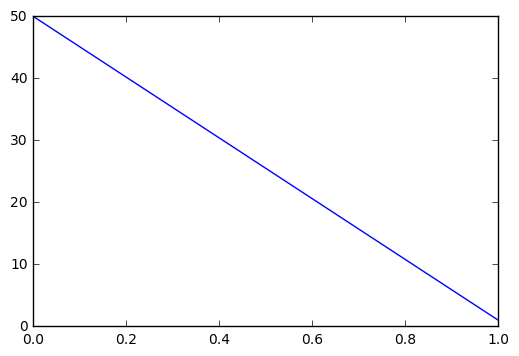

In [8]:
nx = 40
L = 1.0
sol = heat_transfer_1D(nx, 50, 1, 1000.0)
T = sol[...]
x = np.linspace(0, L, nx)
plt.plot(x, T)
plt.show()

Interacting with the Solver
===================

Total number of function evaluation is 5


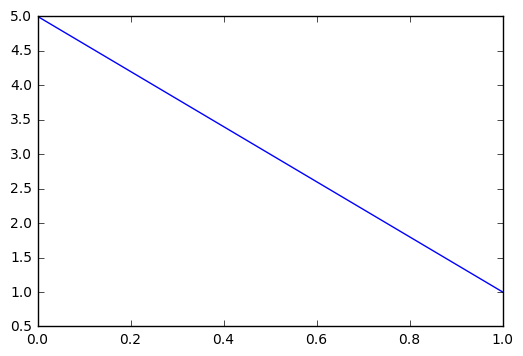

In [28]:
from petsc4py import PETSc
# Viewer not working
options = PETSc.Options()
options.clear()
options.setValue('-snes_monitor', '')
#options.setValue('-snes_monitor_solution', '')
#options.setValue('-pc_type', 'lu')
#options.setValue('-help', '')
options.setValue('-is_coloring_view', '')

nx = 50
L = 1.0
sol = heat_transfer_1D(nx, 5, 1, 1000.0)
T = sol[...]
x = np.linspace(0, L, nx)
plt.plot(x, T)
plt.show()

Since we have an 1D problem (tridiagonal matrix), for each Newton iteration we will need only 3 function $f(x + \Delta x)$ evaluations, plus the $f(x)$ evaluation so that we can calculate

$$
\frac{\partial f}{\partial x} = \frac{f(x + \Delta x) - f(x)}{\Delta x}
$$

in PETSc, the iteration 0 does not compute the Jacobian, it only evaluates the residual.

## Matrix coloring

![alt text](./images/matrix_coloring.jpg)

![alt text](./images/matrix_coloring_small.jpg)